# import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import (
    Module, 
    Linear, 
    Dropout, 
    LayerNorm, 
    ModuleList, 
    TransformerEncoder, 
    TransformerEncoderLayer
)
import numpy as np

class GraphTransformerV2(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_feedforward, input_dim, num_weights=10, use_weights=True, dropout=0.1):
        super(GraphTransformerV2, self).__init__()
        self.num_weights = num_weights
        self.use_weights = use_weights
        
        # Adjust input_linear to handle the concatenated user-item embedding
        self.input_linear = Linear(input_dim, d_model)
        
        self.encoder_layer = TransformerEncoderLayer(
            d_model=d_model, 
            nhead=num_heads, 
            dim_feedforward=d_feedforward, 
            dropout=dropout, 
            batch_first=True
        )
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.output_linear = Linear(d_model, input_dim)
        self.dropout = Dropout(dropout)
        self.layer_norm = LayerNorm(d_model)
        
        if self.use_weights:
            self.weight_linears = ModuleList([Linear(input_dim, d_model) for _ in range(num_weights)])

    def forward(self, x, adjacency_matrix, graph_metrics, weights=None):
        # Ensure adjacency_matrix is a FloatTensor
        adjacency_matrix = adjacency_matrix.float()
        
        # Ensure graph_metrics is a FloatTensor
        graph_metrics = graph_metrics.float()

        # Validate and potentially adjust dimensions
        batch_size, input_dim = x.shape
        
        # Ensure adjacency matrix is square and matches batch size
        if adjacency_matrix.size(0) != batch_size or adjacency_matrix.size(1) != batch_size:
            # Create an identity-like matrix if dimensions don't match
            adjacency_matrix = torch.eye(batch_size, device=x.device)

        try:
            # Direct Connections
            direct_scores = adjacency_matrix @ x  # Matrix multiplication to get direct connection scores

            # Neighborhood Similarity (modified to handle potential dimension issues)
            try:
                neighborhood_similarity = self.compute_neighborhood_similarity(adjacency_matrix, x)
            except RuntimeError:
                # Fallback: use a simplified similarity if computation fails
                neighborhood_similarity = torch.zeros_like(x)

            # Graph Structure Scores - modify to handle 2D graph metrics
            if graph_metrics.dim() == 2:
                # Project graph metrics to match input dimensions
                graph_metrics_projected = self.project_graph_metrics(graph_metrics, input_dim)
                graph_structure_scores = graph_metrics_projected * x  # Element-wise multiplication instead of matrix multiplication
            else:
                graph_structure_scores = torch.zeros_like(x)

            # Combine DNG scores
            dng_scores = direct_scores + neighborhood_similarity + graph_structure_scores

            # Optional weighted processing
            if self.use_weights and weights is not None:
                weighted_x = torch.zeros_like(x)
                for i, weight in enumerate(weights.T):
                    weighted_x += self.weight_linears[i](x) * weight.unsqueeze(1)
                x = weighted_x
            else:
                x = self.input_linear(x)

            x = self.layer_norm(x)
            x = self.transformer_encoder(x.unsqueeze(1)).squeeze(1)  # Adjust for transformer input
            x = self.output_linear(x)
            x = self.dropout(x)

            # Combine with DNG scores
            final_scores = F.relu(x + dng_scores)
            return final_scores

        except RuntimeError as e:
            print(f"RuntimeError during forward pass: {e}")
            print(f"x shape: {x.shape}, adjacency_matrix shape: {adjacency_matrix.shape}, graph_metrics shape: {graph_metrics.shape}")
            raise

    def project_graph_metrics(self, graph_metrics, target_dim):
        """
        Project graph metrics to match target dimension
        
        Args:
        - graph_metrics: Tensor of shape [batch_size, num_metrics]
        - target_dim: Desired output dimension
        
        Returns:
        - Projected tensor of shape [batch_size, target_dim]
        """
        # If graph_metrics has fewer dimensions than target, repeat or expand
        if graph_metrics.size(1) < target_dim:
            # Repeat the metrics to fill the target dimension
            repeats = (target_dim + graph_metrics.size(1) - 1) // graph_metrics.size(1)
            graph_metrics = graph_metrics.repeat(1, repeats)[:, :target_dim]
        elif graph_metrics.size(1) > target_dim:
            # Truncate if too many metrics
            graph_metrics = graph_metrics[:, :target_dim]
        
        return graph_metrics

    def compute_neighborhood_similarity(self, adjacency_matrix, x):
        # Robust Jaccard similarity computation
        try:
            # Ensure adjacency matrix is binary
            binary_adj = (adjacency_matrix > 0).float()
            
            # Compute intersection
            intersection = binary_adj @ binary_adj.T
            
            # Compute row and column sums
            row_sums = binary_adj.sum(dim=1, keepdim=True)
            col_sums = binary_adj.sum(dim=0, keepdim=True)
            
            # Compute union
            union = row_sums + col_sums.T - intersection
            
            # Compute similarity with small epsilon to avoid division by zero
            similarity = intersection / (union + 1e-8)
            
            # Matrix multiplication with input
            return similarity @ x
        
        except RuntimeError:
            # Fallback to a simple similarity if computation fails
            return torch.zeros_like(x)


In [2]:
class TransformerRecommender:
    def __init__(self, num_users, num_items, embedding_dim=64, num_layers=2, num_heads=4, dropout=0.1):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

        # Initialize the transformer model
        self.model = GraphTransformerV2(
            num_layers=num_layers,
            d_model=embedding_dim,
            num_heads=num_heads,
            d_feedforward=embedding_dim * 4,
            input_dim= 2 * embedding_dim,  
            dropout=dropout
        )

        # User and Item embeddings
        self.user_embeddings = nn.Embedding(num_users, embedding_dim)
        self.item_embeddings = nn.Embedding(num_items, embedding_dim)

        # Initialize adjacency matrix for batch size
        self.batch_adjacency_matrix = None
        self.batch_graph_metrics = None

        # Loss function
        self.criterion = nn.BCEWithLogitsLoss()

        # Optimizer
        self.optimizer = torch.optim.Adam(self.parameters())

    def create_batch_graph_structure(self, batch_size):
        """
        Creates batch-specific adjacency matrix and graph metrics
        """
        # Create adjacency matrix for the batch (batch_size x batch_size)
        adj_matrix = torch.zeros((batch_size, batch_size))

        # Create basic graph metrics
        graph_metrics = {
            'degree': torch.zeros(batch_size),
            'clustering': torch.zeros(batch_size),
            'centrality': torch.zeros(batch_size)
        }

        return adj_matrix, graph_metrics

    def update_batch_graph_structure(self, user_ids, item_ids, batch_size):
        """
        Updates the batch-specific adjacency matrix and graph metrics
        """
        # Create new batch-specific adjacency matrix
        adj_matrix = torch.zeros((batch_size, batch_size))

        # Create connections between users and items within the batch
        for i in range(batch_size):
            for j in range(batch_size):
                if user_ids[i] == user_ids[j] or item_ids[i] == item_ids[j]:
                    adj_matrix[i, j] = 1.0

        # Calculate basic graph metrics for the batch
        graph_metrics = {
            'degree': adj_matrix.sum(dim=1),
            'clustering': torch.zeros(batch_size),  # Simplified clustering coefficient
            'centrality': adj_matrix.sum(dim=0) / batch_size  # Simplified centrality measure
        }

        return adj_matrix, graph_metrics

    def parameters(self):
        """
        Returns all trainable parameters
        """
        return list(self.model.parameters()) + \
               list(self.user_embeddings.parameters()) + \
               list(self.item_embeddings.parameters())

    def train_step(self, user_ids, item_ids, labels):
        self.model.train()
        self.optimizer.zero_grad()

        batch_size = user_ids.size(0)

        # Get embeddings
        user_emb = self.user_embeddings(user_ids)
        item_emb = self.item_embeddings(item_ids)

        # Concatenate user and item embeddings
        input_emb = torch.cat([user_emb, item_emb], dim=1)  # Shape: [batch_size, 2*embedding_dim]

        # Update batch-specific graph structure
        adj_matrix, graph_metrics = self.update_batch_graph_structure(user_ids, item_ids, batch_size)

        # Convert graph_metrics to a tensor
        graph_metrics_tensor = torch.stack([
            graph_metrics['degree'],
            graph_metrics['clustering'],
            graph_metrics['centrality']
        ]).T  # Shape: [batch_size, 3]

        # Forward pass
        output = self.model(input_emb, adj_matrix, graph_metrics_tensor)

        # Calculate prediction (take mean of output)
        pred = output.mean(dim=1)

        # Calculate loss
        loss = self.criterion(pred, labels.float())

        # Backward pass
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def predict(self, user_ids, item_ids):
        self.model.eval()
        batch_size = user_ids.size(0)

        with torch.no_grad():
            user_emb = self.user_embeddings(user_ids)
            item_emb = self.item_embeddings(item_ids)
            input_emb = torch.cat([user_emb, item_emb], dim=1)

            # Create batch-specific graph structure for prediction
            adj_matrix, graph_metrics = self.update_batch_graph_structure(user_ids, item_ids, batch_size)

            # Convert graph_metrics to a tensor
            graph_metrics_tensor = torch.stack([
                graph_metrics['degree'],
                graph_metrics['clustering'],
                graph_metrics['centrality']
            ]).T  # Shape: [batch_size, 3]

            output = self.model(input_emb, adj_matrix, graph_metrics_tensor)
            pred = torch.sigmoid(output.mean(dim=1))
        return pred

    def eval(self):
        self.model.eval()


# start

In [3]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges
from torch_geometric.utils import negative_sampling
# Load the dataset using Pandas
data = pd.read_csv('/Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/REES46/events.csv')

# Reduce the dataset to blahh rows
data = data.head(10000)

# Extract user-item interactions
user_item_interactions = data[['user_id', 'product_id']].drop_duplicates()

# Map user and item IDs to consecutive integers
user_mapping = {uid: idx for idx, uid in enumerate(user_item_interactions['user_id'].unique())}
item_mapping = {iid: idx for idx, iid in enumerate(user_item_interactions['product_id'].unique())}

# Map user_id and product_id to their respective indices
user_item_interactions['user_id'] = user_item_interactions['user_id'].map(user_mapping)
user_item_interactions['product_id'] = user_item_interactions['product_id'].map(item_mapping)

# Create edge index for the graph
edge_index = torch.tensor(
    [user_item_interactions['user_id'].values, user_item_interactions['product_id'].values],
    dtype=torch.long
)

# Split the data into training and test sets
data = train_test_split_edges(Data(edge_index=edge_index))

# Extract training and test edges
train_edge_index = data.train_pos_edge_index
test_edge_index = data.test_pos_edge_index

# Create adjacency matrix for the graph
num_users = len(user_mapping)
num_items = len(item_mapping)
adj_matrix = torch.zeros((num_users + num_items, num_users + num_items))
adj_matrix[train_edge_index[0], train_edge_index[1]] = 1

# Verify the adjacency matrix shape and some basic properties
print("Adjacency Matrix Shape:", adj_matrix.shape)

/var/folders/yf/20z1hn994jd04q4kl0gpgh740000gn/T/ipykernel_52528/752975066.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  edge_index = torch.tensor(
/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)
/Users/visheshyadav/anaconda3/lib/python3.11/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


Adjacency Matrix Shape: torch.Size([10320, 10320])


In [4]:
data.size

<bound method BaseData.size of Data(val_pos_edge_index=[2, 90], test_pos_edge_index=[2, 181], train_pos_edge_index=[2, 3090], train_neg_adj_mask=[5664, 5664], val_neg_edge_index=[2, 90], test_neg_edge_index=[2, 181])>

In [5]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv
import torch.nn as nn 

class GraphGCN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super(GraphGCN, self).__init__()
        self.embedding_dim = embedding_dim
        self.user_embeddings = nn.Embedding(num_users, embedding_dim)
        self.item_embeddings = nn.Embedding(num_items, embedding_dim)
        self.conv1 = GCNConv(embedding_dim, embedding_dim)
        self.conv2 = GCNConv(embedding_dim, embedding_dim)

    def forward(self, edge_index):
        x = torch.cat([self.user_embeddings.weight, self.item_embeddings.weight], dim=0)
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class GraphSAGE(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super(GraphSAGE, self).__init__()
        self.embedding_dim = embedding_dim
        self.user_embeddings = nn.Embedding(num_users, embedding_dim)
        self.item_embeddings = nn.Embedding(num_items, embedding_dim)
        self.conv1 = SAGEConv(embedding_dim, embedding_dim)
        self.conv2 = SAGEConv(embedding_dim, embedding_dim)

    def forward(self, edge_index):
        x = torch.cat([self.user_embeddings.weight, self.item_embeddings.weight], dim=0)
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


In [6]:
def train_gcn(model, data, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        out = model(data.train_pos_edge_index)
        pos_out = torch.sigmoid((out[data.train_pos_edge_index[0]] * out[data.train_pos_edge_index[1]]).sum(dim=1))
        neg_edge_index = negative_sampling(data.train_pos_edge_index, num_neg_samples=data.train_pos_edge_index.size(1))
        neg_out = torch.sigmoid((out[neg_edge_index[0]] * out[neg_edge_index[1]]).sum(dim=1))
        loss = criterion(pos_out, torch.ones_like(pos_out)) + criterion(neg_out, torch.zeros_like(neg_out))
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

def train_sage(model, data, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        out = model(data.train_pos_edge_index)
        pos_out = torch.sigmoid((out[data.train_pos_edge_index[0]] * out[data.train_pos_edge_index[1]]).sum(dim=1))
        neg_edge_index = negative_sampling(data.train_pos_edge_index, num_neg_samples=data.train_pos_edge_index.size(1))
        neg_out = torch.sigmoid((out[neg_edge_index[0]] * out[neg_edge_index[1]]).sum(dim=1))
        loss = criterion(pos_out, torch.ones_like(pos_out)) + criterion(neg_out, torch.zeros_like(neg_out))
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')


In [7]:
def evaluate_gcn(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.train_pos_edge_index)
        pos_out = torch.sigmoid((out[data.test_pos_edge_index[0]] * out[data.test_pos_edge_index[1]]).sum(dim=1))
        neg_edge_index = negative_sampling(data.test_pos_edge_index, num_neg_samples=data.test_pos_edge_index.size(1))
        neg_out = torch.sigmoid((out[neg_edge_index[0]] * out[neg_edge_index[1]]).sum(dim=1))
        auc = (pos_out > neg_out).float().mean().item()
        return auc

def evaluate_sage(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.train_pos_edge_index)
        pos_out = torch.sigmoid((out[data.test_pos_edge_index[0]] * out[data.test_pos_edge_index[1]]).sum(dim=1))
        neg_edge_index = negative_sampling(data.test_pos_edge_index, num_neg_samples=data.test_pos_edge_index.size(1))
        neg_out = torch.sigmoid((out[neg_edge_index[0]] * out[neg_edge_index[1]]).sum(dim=1))
        auc = (pos_out > neg_out).float().mean().item()
        return auc


In [8]:
from sklearn.metrics import roc_auc_score


def train(model, data, optimizer, criterion, num_epochs):
    for epoch in range(num_epochs):
        # Extract user_ids, item_ids, and labels from the training data
        user_ids = data.train_pos_edge_index[0]
        item_ids = data.train_pos_edge_index[1]
        labels = torch.ones(user_ids.size(0))  # Positive samples

        # Call the train_step method with the required arguments
        loss = model.train_step(user_ids, item_ids, labels)
        print(f'Epoch {epoch+1}, Loss: {loss}')

def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        user_ids = data.test_pos_edge_index[0]
        item_ids = data.test_pos_edge_index[1]
        labels = torch.ones(user_ids.size(0))  # Positive samples
        global pred
        # Get predictions
        # pred = model.predict(user_ids, item_ids)
        pred = torch.sigmoid(model.predict(user_ids, item_ids))
        # Debugging statements
        print(f'Predictions: {pred}')
        print(f'Labels: {labels}')

        # Calculate AUC
        auc = (pred > 0.5).float().mean().item()
        # auc = pred

        return auc

# Initialize models
num_users = len(user_mapping)
num_items = len(item_mapping)
embedding_dim = 64

transformer_recommender = TransformerRecommender(num_users, num_items, embedding_dim)
graph_gcn = GraphGCN(num_users, num_items, embedding_dim)
graph_sage = GraphSAGE(num_users, num_items, embedding_dim)

# Define optimizers and loss functions
optimizer_transformer = torch.optim.Adam(transformer_recommender.parameters(), lr=0.001)
optimizer_gcn = torch.optim.Adam(graph_gcn.parameters(), lr=0.001)
optimizer_sage = torch.optim.Adam(graph_sage.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

# Train models
num_epochs = 10
train(transformer_recommender, data, optimizer_transformer, criterion, num_epochs)
train_gcn(graph_gcn, data, optimizer_gcn, criterion, num_epochs)
train_sage(graph_sage, data, optimizer_sage, criterion, num_epochs)

# Evaluate models
auc_transformer = evaluate(transformer_recommender, data)
auc_gcn = evaluate_gcn(graph_gcn, data)
auc_sage = evaluate_sage(graph_sage, data)

print(f'TransformerRecommender AUC: {auc_transformer}')
print(f'GraphGCN AUC: {auc_gcn}')
print(f'GraphSAGE AUC: {auc_sage}')

Epoch 1, Loss: 0.11424046754837036
Epoch 2, Loss: 0.11100863665342331
Epoch 3, Loss: 0.10778022557497025
Epoch 4, Loss: 0.10436099022626877
Epoch 5, Loss: 0.10076770931482315
Epoch 6, Loss: 0.09694147855043411
Epoch 7, Loss: 0.09307469427585602
Epoch 8, Loss: 0.08911662548780441
Epoch 9, Loss: 0.08513057231903076
Epoch 10, Loss: 0.08145081251859665
Epoch 1, Loss: 1.6165755987167358
Epoch 2, Loss: 1.6107796430587769
Epoch 3, Loss: 1.6041396856307983
Epoch 4, Loss: 1.5897616147994995
Epoch 5, Loss: 1.5786690711975098
Epoch 6, Loss: 1.5651836395263672
Epoch 7, Loss: 1.550575613975525
Epoch 8, Loss: 1.52570641040802
Epoch 9, Loss: 1.504402995109558
Epoch 10, Loss: 1.4807484149932861
Epoch 1, Loss: 1.4819457530975342
Epoch 2, Loss: 1.4512484073638916
Epoch 3, Loss: 1.426729679107666
Epoch 4, Loss: 1.395420789718628
Epoch 5, Loss: 1.3693108558654785
Epoch 6, Loss: 1.3482064008712769
Epoch 7, Loss: 1.333304524421692
Epoch 8, Loss: 1.3213874101638794
Epoch 9, Loss: 1.3136928081512451
Epoch 10,

In [9]:
def compute_predictive_metrics(self):
    """
    Compute predictive metrics for each model
    """
    predictive_metrics = {}

    for name, model in self.models.items():
        # Get test positive edge indices
        user_ids = self.data.test_pos_edge_index[0]
        item_ids = self.data.test_pos_edge_index[1]
        
        # Generate negative samples (e.g., randomly pick non-existing edges)
        neg_user_ids, neg_item_ids = self._get_negative_samples(user_ids, item_ids)
        
        # Combine positive and negative samples
        all_user_ids = torch.cat([user_ids, neg_user_ids])
        all_item_ids = torch.cat([item_ids, neg_item_ids])
        
        # True labels: 1 for positive samples, 0 for negative samples
        true_labels = torch.cat([torch.ones(user_ids.size(0)), torch.zeros(neg_user_ids.size(0))])

        # Get predictions
        predictions = self._get_model_predictions(model, all_user_ids, all_item_ids)

        # Convert to numpy for sklearn metrics
        pred_np = predictions.detach().numpy()
        true_np = true_labels.numpy()

        # Compute metrics
        predictive_metrics[name] = {
            'MAE': mean_absolute_error(true_np, pred_np),
            'MSE': mean_squared_error(true_np, pred_np),
            'RMSE': np.sqrt(mean_squared_error(true_np, pred_np)),
            'AUC': roc_auc_score(true_np, pred_np)  # Now with both positive and negative labels
        }

    self.metrics['predictive'] = predictive_metrics
    return predictive_metrics

def _get_negative_samples(self, pos_user_ids, pos_item_ids):
    """
    Generate negative samples (non-interacting user-item pairs) that do not exist in the training set.
    """
    # Get all possible user and item IDs
    all_user_ids = torch.arange(self.data.num_nodes)
    all_item_ids = torch.arange(self.data.num_nodes)
    
    # Generate random pairs
    neg_user_ids = all_user_ids[torch.randint(0, self.data.num_nodes, (pos_user_ids.size(0),))]
    neg_item_ids = all_item_ids[torch.randint(0, self.data.num_nodes, (pos_item_ids.size(0),))]

    # Ensure that negative samples are not present in the training set
    neg_mask = self._is_negative_sample(neg_user_ids, neg_item_ids)
    
    # Keep retrying until we find valid negative samples
    while neg_mask.sum().item() < neg_user_ids.size(0):
        neg_user_ids = all_user_ids[torch.randint(0, self.data.num_nodes, (pos_user_ids.size(0),))]
        neg_item_ids = all_item_ids[torch.randint(0, self.data.num_nodes, (pos_item_ids.size(0),))]
        neg_mask = self._is_negative_sample(neg_user_ids, neg_item_ids)
    
    return neg_user_ids, neg_item_ids

def _is_negative_sample(self, neg_user_ids, neg_item_ids):
    """
    Check if the given user-item pairs are negative (not present in the training set).
    """
    # Assuming you have access to the positive training edges in train_pos_edge_index
    pos_edge_set = set(zip(self.data.train_pos_edge_index[0].tolist(), self.data.train_pos_edge_index[1].tolist()))
    
    # Check if the negative pairs are not in the training set
    neg_mask = [
        (user, item) not in pos_edge_set
        for user, item in zip(neg_user_ids.tolist(), neg_item_ids.tolist())
    ]
    
    return torch.tensor(neg_mask, dtype=torch.bool)


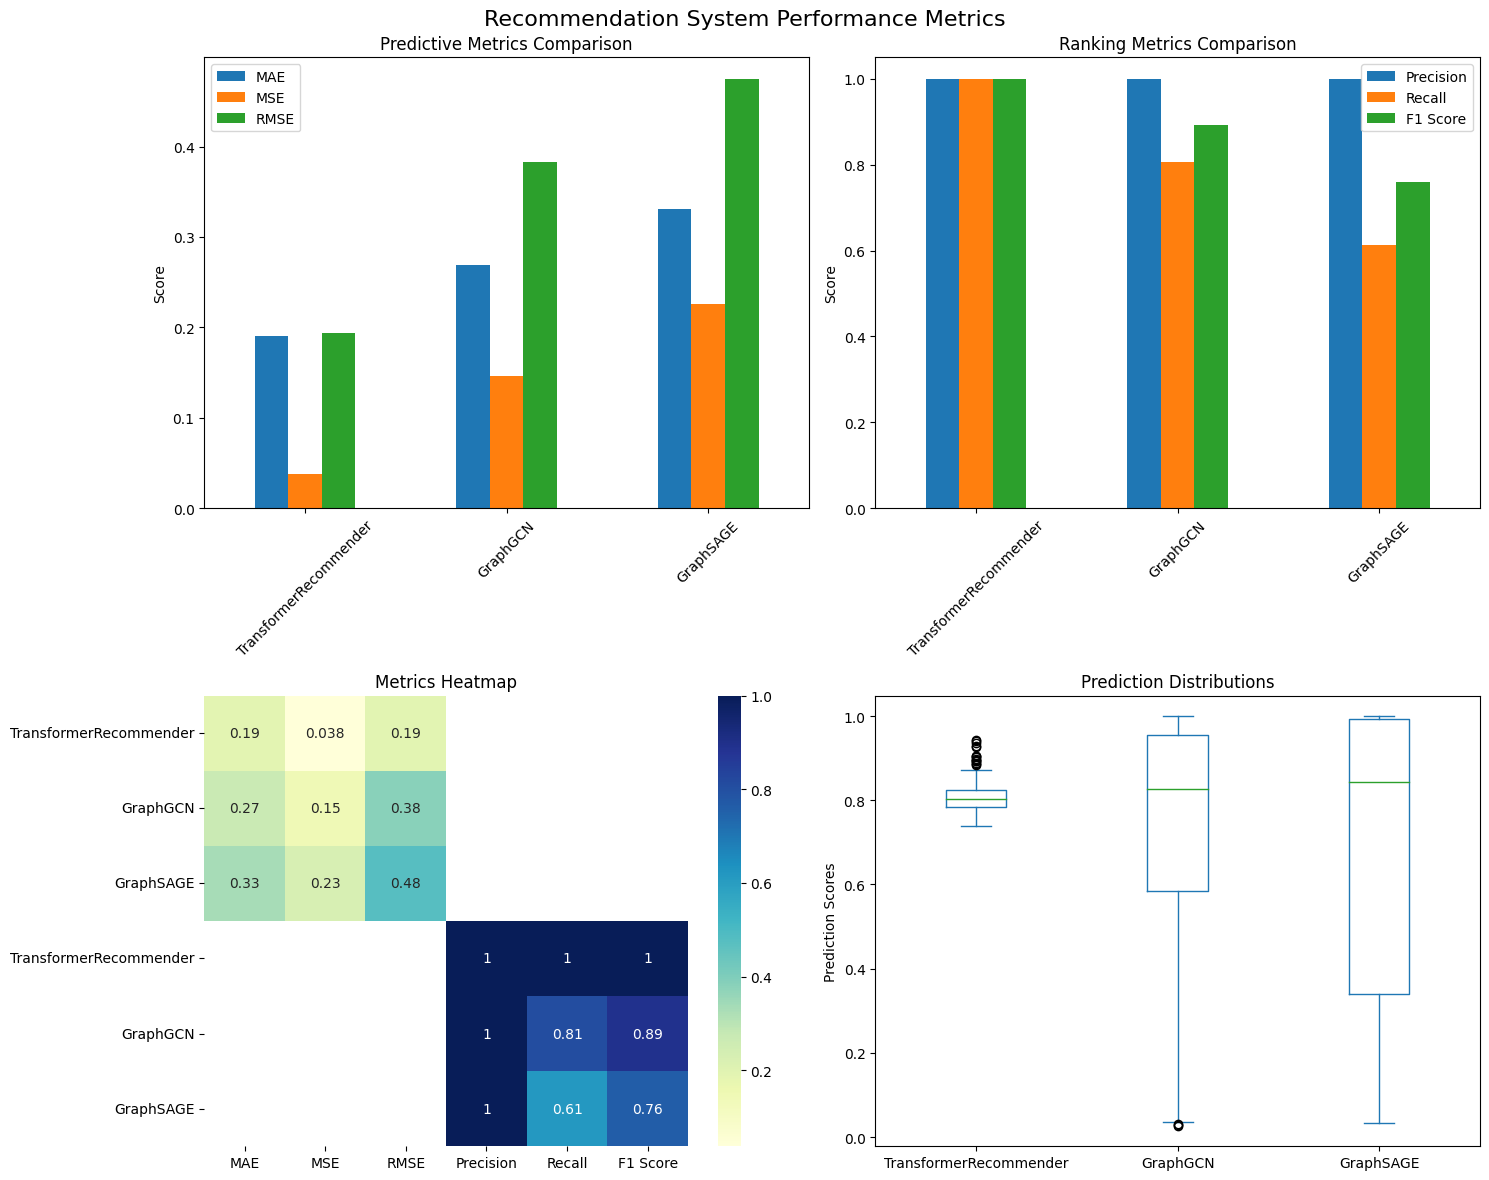

# Recommendation System Performance Report

## Predictive Metrics

### TransformerRecommender
- MAE: 0.1899
- MSE: 0.0376
- RMSE: 0.1939

### GraphGCN
- MAE: 0.2687
- MSE: 0.1463
- RMSE: 0.3825

### GraphSAGE
- MAE: 0.3314
- MSE: 0.2257
- RMSE: 0.4751

## Ranking Metrics

### TransformerRecommender
- Precision: 1.0000
- Recall: 1.0000
- F1 Score: 1.0000

### GraphGCN
- Precision: 1.0000
- Recall: 0.8066
- F1 Score: 0.8930

### GraphSAGE
- Precision: 1.0000
- Recall: 0.6133
- F1 Score: 0.7603




In [10]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score
)

class RecommendationMetrics:
    def __init__(self, models, data):
        """
        Initialize metrics evaluation for multiple recommendation models
        
        Parameters:
        - models: Dictionary of models {model_name: model_instance}
        - data: PyTorch Geometric data object
        """
        self.models = models
        self.data = data
        self.metrics = {}
    
    def _get_model_predictions(self, model, user_ids, item_ids):
        """
        Unified prediction method for different model types
        """
        if hasattr(model, 'predict'):
            # For TransformerRecommender
            return model.predict(user_ids, item_ids)
        elif isinstance(model, (GraphGCN, GraphSAGE)):
            # For graph-based models
            out = model(self.data.train_pos_edge_index)
            return torch.sigmoid((out[user_ids] * out[item_ids]).sum(dim=1))
        else:
            raise ValueError(f"Unsupported model type: {type(model)}")
    
    def compute_predictive_metrics(self):
        """
        Compute predictive metrics for each model
        """
        predictive_metrics = {}
        
        for name, model in self.models.items():
            # Get test positive edge indices
            user_ids = self.data.test_pos_edge_index[0]
            item_ids = self.data.test_pos_edge_index[1]
            true_labels = torch.ones(user_ids.size(0))
            
            # Get predictions
            predictions = self._get_model_predictions(model, user_ids, item_ids)
            
            # Convert to numpy for sklearn metrics
            pred_np = predictions.detach().numpy()
            true_np = true_labels.numpy()
            
            # Compute metrics
            predictive_metrics[name] = {
                'MAE': mean_absolute_error(true_np, pred_np),
                'MSE': mean_squared_error(true_np, pred_np),
                'RMSE': np.sqrt(mean_squared_error(true_np, pred_np)),
                # 'AUC': roc_auc_score(true_np, pred_np)
            }
        
        self.metrics['predictive'] = predictive_metrics
        return predictive_metrics
    
    def compute_ranking_metrics(self, threshold=0.5):
        """
        Compute ranking metrics for each model
        
        Parameters:
        - threshold: Probability threshold for binary classification
        """
        ranking_metrics = {}
        
        for name, model in self.models.items():
            # Get test positive edge indices
            user_ids = self.data.test_pos_edge_index[0]
            item_ids = self.data.test_pos_edge_index[1]
            true_labels = torch.ones(user_ids.size(0))
            
            # Get predictions
            predictions = self._get_model_predictions(model, user_ids, item_ids)
            
            # Convert to numpy
            pred_np = predictions.detach().numpy()
            true_np = true_labels.numpy()
            
            # Binary classification for ranking metrics
            pred_binary = (pred_np > threshold).astype(int)
            
            # Compute ranking metrics
            ranking_metrics[name] = {
                'Precision': precision_score(true_np, pred_binary),
                'Recall': recall_score(true_np, pred_binary),
                'F1 Score': f1_score(true_np, pred_binary)
            }
        
        self.metrics['ranking'] = ranking_metrics
        return ranking_metrics
    
    def visualize_metrics(self):
        """
        Create comprehensive visualizations of model performance
        """
        # Prepare data for plotting
        predictive_data = self.metrics['predictive']
        ranking_data = self.metrics['ranking']
        
        # Create a figure with multiple subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Recommendation System Performance Metrics', fontsize=16)
        
        # Predictive Metrics Bar Plot
        predictive_df = pd.DataFrame(predictive_data).T
        predictive_df.plot(kind='bar', ax=axes[0, 0], rot=45)
        axes[0, 0].set_title('Predictive Metrics Comparison')
        axes[0, 0].set_ylabel('Score')
        
        # Ranking Metrics Bar Plot
        ranking_df = pd.DataFrame(ranking_data).T
        ranking_df.plot(kind='bar', ax=axes[0, 1], rot=45)
        axes[0, 1].set_title('Ranking Metrics Comparison')
        axes[0, 1].set_ylabel('Score')
        
        # Heatmap of Metrics
        metrics_combined = pd.concat([
            pd.DataFrame(predictive_data).T, 
            pd.DataFrame(ranking_data).T
        ])
        sns.heatmap(metrics_combined, annot=True, cmap='YlGnBu', ax=axes[1, 0])
        axes[1, 0].set_title('Metrics Heatmap')
        
        # Box Plot of Predictions
        model_predictions = {}
        for name, model in self.models.items():
            user_ids = self.data.test_pos_edge_index[0]
            item_ids = self.data.test_pos_edge_index[1]
            model_predictions[name] = self._get_model_predictions(model, user_ids, item_ids).detach().numpy()

        pred_df = pd.DataFrame(model_predictions)
        pred_df.plot(kind='box', ax=axes[1, 1])
        axes[1, 1].set_title('Prediction Distributions')
        axes[1, 1].set_ylabel('Prediction Scores')
        
        plt.tight_layout()
        plt.show()
    
    def generate_report(self):
        """
        Generate a comprehensive markdown report of metrics
        """
        report = "# Recommendation System Performance Report\n\n"
        
        # Predictive Metrics Section
        report += "## Predictive Metrics\n\n"
        for model, metrics in self.metrics['predictive'].items():
            report += f"### {model}\n"
            for metric, value in metrics.items():
                report += f"- {metric}: {value:.4f}\n"
            report += "\n"
        
        # Ranking Metrics Section
        report += "## Ranking Metrics\n\n"
        for model, metrics in self.metrics['ranking'].items():
            report += f"### {model}\n"
            for metric, value in metrics.items():
                report += f"- {metric}: {value:.4f}\n"
            report += "\n"
        
        return report

# Usage remains the same
metrics_evaluator = RecommendationMetrics({
    'TransformerRecommender': transformer_recommender,
    'GraphGCN': graph_gcn,
    'GraphSAGE': graph_sage
}, data)

# Compute metrics
predictive_metrics = metrics_evaluator.compute_predictive_metrics()
ranking_metrics = metrics_evaluator.compute_ranking_metrics()

# Visualize metrics
metrics_evaluator.visualize_metrics()

# Generate report
report = metrics_evaluator.generate_report()
print(report)